In [86]:
import pandas as pd
import matplotlib.pyplot as plt

#df = pd.read_csv(r"C:\Users\zahri\anaconda_projects\AsaiProjekt\Asai-Projekt\heart.csv")
df = pd.read_csv("/Users/aurelia/Documents/GitHub/Asai-Projekt/heart.csv")

styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df

print(f"Anzahl der Zeilen (Patienten): {df.shape[0]}")
print(f"Anzahl der Spalten (Features): {df.shape[1]}")
# Ersten Blick auf die Daten werfen
#print(df.head())             # Zeigt die ersten 5 Zeilen
#print(df.info())             # Gibt Datentypen und Nullwerte an
#print(df.describe())         # Statistische Übersicht (Mittelwert, Std., etc.)

# Optional: Spaltennamen anzeigen
print("Spalten:", df.columns.tolist())

Anzahl der Zeilen (Patienten): 1025
Anzahl der Spalten (Features): 14
Spalten: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


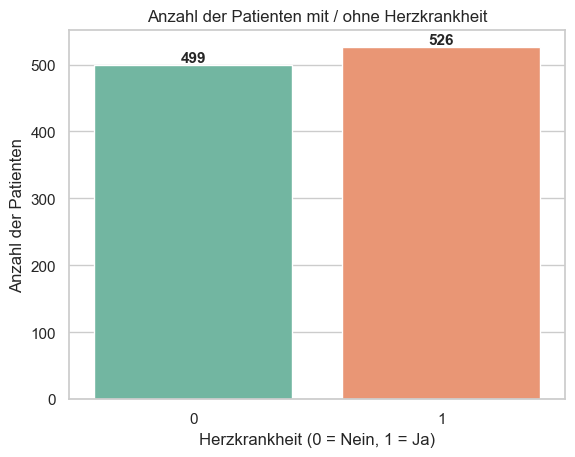

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# Balkendiagramm OHNE FutureWarning
ax = sns.countplot(x='target', data=df, hue='target', palette='Set2', legend=False)

# Achsentitel
plt.title('Anzahl der Patienten mit / ohne Herzkrankheit')
plt.xlabel('Herzkrankheit (0 = Nein, 1 = Ja)')
plt.ylabel('Anzahl der Patienten')

# Zahlen über Balken schreiben
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold')

# Plot anzeigen
plt.show()

In [88]:
#Ausreißer suchen
# Welche Altersbereiche gibt es?
print("Alter (min/max):", df['age'].min(), df['age'].max())

# Extrem hohe/niedrige Cholesterinwerte
print(df[df['chol'] > 600])
print(df[df['chol'] < 100])

# Maximalpuls über physiologisch plausibler Grenze?
print(df[df['thalach'] > 220])

# Negative oldpeak-Werte (sollten nicht vorkommen)
print(df[df['oldpeak'] < 0])


Alter (min/max): 29 77
Empty DataFrame
Columns: [age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal, target]
Index: []
Empty DataFrame
Columns: [age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal, target]
Index: []
Empty DataFrame
Columns: [age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal, target]
Index: []
Empty DataFrame
Columns: [age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal, target]
Index: []


🔍 Genauigkeit: 0.9853658536585366

🧾 Klassifikationsbericht:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



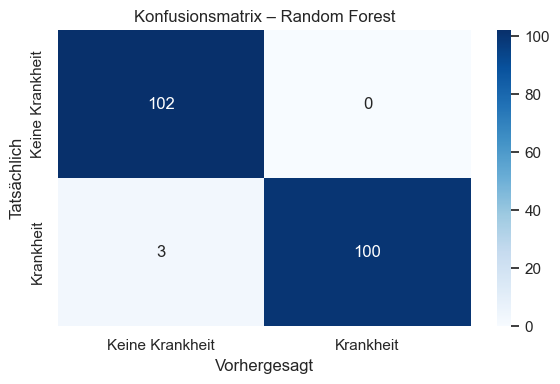

 False Negatives – Krank, aber als gesund erkannt:
     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
96    57    0   0       128   303    0        0      159      0      0.0   
420   57    0   0       128   303    0        0      159      0      0.0   
490   57    0   0       128   303    0        0      159      0      0.0   

     slope  ca  thal  target  
96       2   1     2       1  
420      2   1     2       1  
490      2   1     2       1  


In [89]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# 2. Features und Zielspalte trennen
X = df.drop("target", axis=1)
y = df["target"]

# 3. Skalieren (optional, aber nützlich)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 5. Random Forest Modell trainieren
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 6. Vorhersagen machen
y_pred = model.predict(X_test)

# 7. Bewertung: Genauigkeit & Bericht
print(" Genauigkeit:", accuracy_score(y_test, y_pred))
print("\n Klassifikationsbericht:\n", classification_report(y_test, y_pred))

# 8. Konfusionsmatrix berechnen
cm = confusion_matrix(y_test, y_pred)

# 9. Konfusionsmatrix grafisch darstellen
labels = ['Keine Krankheit', 'Krankheit']
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Vorhergesagt')
plt.ylabel('Tatsächlich')
plt.title('Konfusionsmatrix – Random Forest')
plt.tight_layout()
plt.show()

# Vorhersagen auf Testdaten
y_pred = model.predict(X_test)

# Umwandeln in DataFrame für einfache Filterung
results = pd.DataFrame({
    'y_true': y_test.values,
    'y_pred': y_pred
}, index=y_test.index)  # Index beibehalten, damit wir die Zeile im Original-Datensatz wiederfinden

# False Negatives herausfiltern
false_negatives = results[(results['y_true'] == 1) & (results['y_pred'] == 0)]

# Originaldaten dieser Fälle anzeigen (optional: mit nur den wichtigsten Spalten)
print(" False Negatives – Krank, aber als gesund erkannt:")
print(df.loc[false_negatives.index])  # zeigt die Originalzeilen der Patienten



In [90]:
def remove_duplicates_keep_first(df):
    seen = set()                # Set für eindeutige Zeilen (als Tupel)
    duplicate_indices = []      # Liste für Duplikat-Indizes
    indices_to_drop = []        # Indizes, die wir löschen wollen

    for idx, row in df.iterrows():
        row_tuple = tuple(row)  # Zeile als Tupel (Index wird nicht mitgenommen, nur Spalten)
        if row_tuple in seen:
            indices_to_drop.append(idx)  # markiere als Duplikat
            duplicate_indices.append(idx)
        else:
            seen.add(row_tuple)

    # DataFrame ohne Duplikate zurückgeben
    df_clean = df.drop(index=indices_to_drop).reset_index(drop=True)

    print(f"Anzahl entfernte Duplikate: {len(indices_to_drop)}")
    print(f"Duplikate wurden bei Indizes entfernt: {duplicate_indices}")

    return df_clean, duplicate_indices

# Anwendung auf dein DataFrame
df_clean, duplikat_liste = remove_duplicates_keep_first(df)



Anzahl entfernte Duplikate: 723
Duplikate wurden bei Indizes entfernt: [15, 31, 43, 55, 61, 64, 79, 82, 83, 84, 86, 92, 93, 103, 112, 115, 118, 120, 121, 127, 130, 132, 133, 134, 136, 138, 150, 153, 155, 157, 162, 164, 165, 176, 178, 180, 186, 187, 188, 192, 195, 200, 201, 202, 204, 206, 207, 208, 209, 211, 213, 214, 217, 219, 221, 222, 223, 226, 229, 230, 235, 236, 238, 241, 242, 243, 246, 247, 249, 250, 251, 253, 257, 259, 261, 263, 264, 265, 266, 272, 273, 275, 277, 278, 283, 284, 285, 289, 290, 293, 294, 295, 296, 298, 302, 303, 306, 307, 308, 310, 311, 312, 314, 315, 316, 317, 318, 324, 325, 326, 329, 330, 335, 336, 338, 340, 341, 344, 345, 346, 347, 350, 351, 352, 354, 357, 359, 360, 362, 364, 365, 370, 371, 372, 375, 378, 379, 381, 383, 385, 386, 387, 388, 390, 392, 393, 394, 395, 397, 398, 399, 400, 401, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 422, 423, 424, 428, 430, 432, 433, 435, 436, 439, 440, 441, 442, 443, 444, 445, 446, 4

🔍 Anzahl Duplikate vor dem Entfernen: 723
👀 Duplikate:
      age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
15     34    0   1       118   210    0        1      192      0      0.7   
31     50    0   1       120   244    0        1      162      0      1.1   
43     46    1   0       120   249    0        0      144      0      0.8   
55     55    1   0       140   217    0        1      111      1      5.6   
61     66    0   2       146   278    0        0      152      0      0.0   
...   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
1020   59    1   1       140   221    0        1      164      1      0.0   
1021   60    1   0       125   258    0        0      141      1      2.8   
1022   47    1   0       110   275    0        0      118      1      1.0   
1023   50    0   0       110   254    0        0      159      0      0.0   
1024   54    1   0       120   188    0        1      113      0      1.4   

      slope  ca  tha

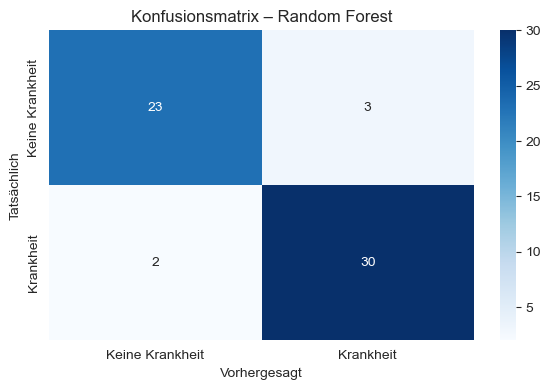

🚨 False Negatives – Krank, aber als gesund erkannt:
     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
38    64    1   0       128   263    0        1      105      1      0.2   
353   57    1   0       110   201    0        1      126      1      1.5   

     slope  ca  thal  target  
38       1   1     3       1  
353      1   0     1       1  


In [29]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv("/Users/aurelia/Documents/GitHub/Asai-Projekt/heart.csv")
# 1. Duplikate entfernen (vorher anzeigen)
print("Anzahl Duplikate vor dem Entfernen:", df.duplicated().sum())
print("Duplikate:")
print(df[df.duplicated()])

# Entfernen
df = df.drop_duplicates()
print(" Anzahl Duplikate nach dem Entfernen:", df.duplicated().sum())

# 2. Features und Zielspalte trennen
X = df.drop("target", axis=1)
y = df["target"]

# 3. Skalieren (optional, aber nützlich)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.19, random_state=19
)

# 5. Random Forest Modell trainieren
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 6. Vorhersagen machen
y_pred = model.predict(X_test)

# 7. Bewertung: Genauigkeit & Bericht
print(" Genauigkeit:", accuracy_score(y_test, y_pred))
print("\n Klassifikationsbericht:\n", classification_report(y_test, y_pred))

# 8. Konfusionsmatrix berechnen
cm = confusion_matrix(y_test, y_pred)

# 9. Konfusionsmatrix grafisch darstellen
labels = ['Keine Krankheit', 'Krankheit']
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Vorhergesagt')
plt.ylabel('Tatsächlich')
plt.title('Konfusionsmatrix – Random Forest')
plt.tight_layout()
plt.show()

# 10. False Negatives analysieren
results = pd.DataFrame({
    'y_true': y_test.values,
    'y_pred': y_pred
}, index=y_test.index)

false_negatives = results[(results['y_true'] == 1) & (results['y_pred'] == 0)]

print(" False Negatives – Krank, aber als gesund erkannt:")
print(df.loc[false_negatives.index])


🔍 Anzahl Duplikate vor dem Entfernen: 723
👀 Duplikate:
      age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
15     34    0   1       118   210    0        1      192      0      0.7   
31     50    0   1       120   244    0        1      162      0      1.1   
43     46    1   0       120   249    0        0      144      0      0.8   
55     55    1   0       140   217    0        1      111      1      5.6   
61     66    0   2       146   278    0        0      152      0      0.0   
...   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
1020   59    1   1       140   221    0        1      164      1      0.0   
1021   60    1   0       125   258    0        0      141      1      2.8   
1022   47    1   0       110   275    0        0      118      1      1.0   
1023   50    0   0       110   254    0        0      159      0      0.0   
1024   54    1   0       120   188    0        1      113      0      1.4   

      slope  ca  tha

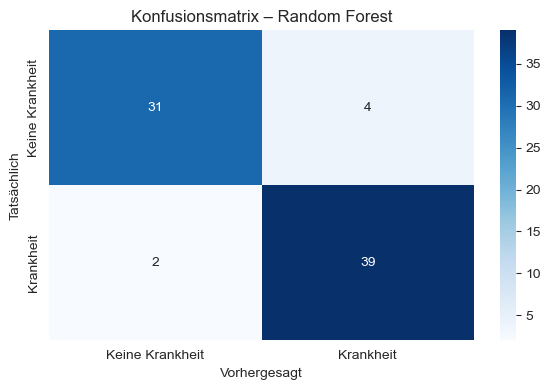

🚨 False Negatives – Krank, aber als gesund erkannt:
     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
38    64    1   0       128   263    0        1      105      1      0.2   
353   57    1   0       110   201    0        1      126      1      1.5   

     slope  ca  thal  target  
38       1   1     3       1  
353      1   0     1       1  


In [49]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#  Daten einlesen
df = pd.read_csv("/Users/aurelia/Documents/GitHub/Asai-Projekt/heart.csv")

# 1. Duplikate entfernen (vorher anzeigen)
print(" Anzahl Duplikate vor dem Entfernen:", df.duplicated().sum())
print(" Duplikate:")
print(df[df.duplicated()])

df = df.drop_duplicates()
print(" Anzahl Duplikate nach dem Entfernen:", df.duplicated().sum())

# 2. Features und Zielspalte trennen
X = df.drop("target", axis=1)
y = df["target"]

# 3. Skalieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=19
)

# 🔧 5. Random Forest Parameter anpassen
rf_params = {
    'n_estimators': 60,         # Anzahl der Bäume
    'max_depth': 20,              # Maximale Tiefe der Bäume
    'min_samples_split': 7,      # Mindestanzahl an Samples zum Splitten eines Knotens
    'min_samples_leaf': 2,       # Mindestanzahl an Samples in einem Blatt
    'max_features': 'sqrt',      # Anzahl der Features pro Split (z. B. 'sqrt', 'log2' oder eine Zahl)
    'random_state': 42         # Für Reproduzierbarkeit
}

model = RandomForestClassifier(**rf_params)
model.fit(X_train, y_train)

# 6. Vorhersagen machen
y_pred = model.predict(X_test)

# 7. Bewertung
print(" Genauigkeit:", accuracy_score(y_test, y_pred))
print("\n Klassifikationsbericht:\n", classification_report(y_test, y_pred))

# 8. Konfusionsmatrix berechnen
cm = confusion_matrix(y_test, y_pred)

# 9. Konfusionsmatrix darstellen
labels = ['Keine Krankheit', 'Krankheit']
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Vorhergesagt')
plt.ylabel('Tatsächlich')
plt.title('Konfusionsmatrix – Random Forest')
plt.tight_layout()
plt.show()

# 10. False Negatives analysieren
results = pd.DataFrame({
    'y_true': y_test.values,
    'y_pred': y_pred
}, index=y_test.index)

false_negatives = results[(results['y_true'] == 1) & (results['y_pred'] == 0)]

print(" False Negatives – Krank, aber als gesund erkannt:")
print(df.loc[false_negatives.index])


 Duplikate vor Entfernen: 723
 Duplikate nach Entfernen: 0
 Random Forest Accuracy: 0.8852459016393442
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        26
           1       0.89      0.91      0.90        35

    accuracy                           0.89        61
   macro avg       0.88      0.88      0.88        61
weighted avg       0.89      0.89      0.88        61

 Logistische Regression Accuracy: 0.8852459016393442
              precision    recall  f1-score   support

           0       0.85      0.88      0.87        26
           1       0.91      0.89      0.90        35

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.88        61
weighted avg       0.89      0.89      0.89        61

 Stacking (RF + LR → LR) Accuracy: 0.8852459016393442
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        26
           1       0.89    

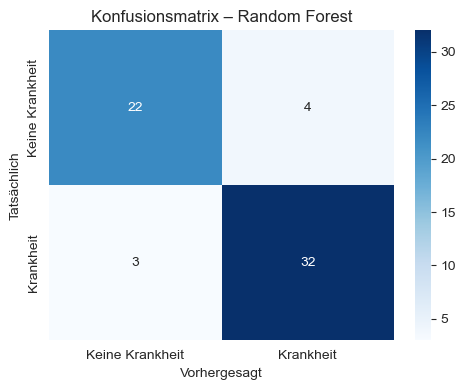

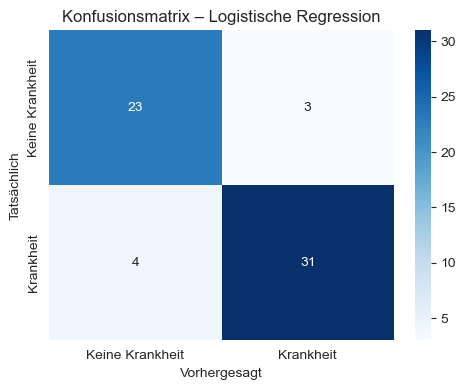

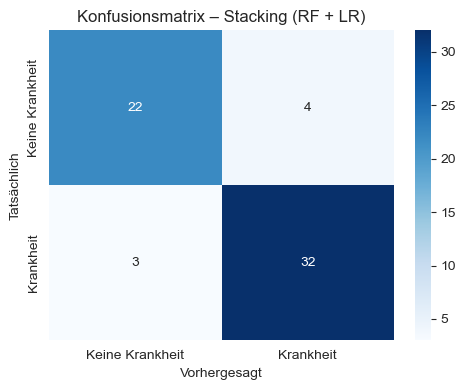

In [52]:
#Stacking
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Daten laden
df = pd.read_csv("/Users/aurelia/Documents/GitHub/Asai-Projekt/heart.csv")

# Duplikate anzeigen und entfernen
print(" Duplikate vor Entfernen:", df.duplicated().sum())
df = df.drop_duplicates()
print(" Duplikate nach Entfernen:", df.duplicated().sum())

# Features und Ziel
X = df.drop("target", axis=1)
y = df["target"]

# Skalieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Trainings-/Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=19
)
#Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print(" Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))
#Logistische Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
print(" Logistische Regression Accuracy:", accuracy_score(y_test, lr_pred))
print(classification_report(y_test, lr_pred))

# stacking
# Basismodelle
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('lr', LogisticRegression(max_iter=1000))
]

# Meta-Modell: logistische Regression
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,       # 5-fache Crossvalidation für Meta-Modell-Training
    n_jobs=-1
)

stacked_model.fit(X_train, y_train)
stacked_pred = stacked_model.predict(X_test)
print(" Stacking (RF + LR → LR) Accuracy:", accuracy_score(y_test, stacked_pred))
print(classification_report(y_test, stacked_pred))
#Konfusionsmatrix
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Keine Krankheit', 'Krankheit']
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Vorhergesagt')
    plt.ylabel('Tatsächlich')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(y_test, rf_pred, "Konfusionsmatrix – Random Forest")
plot_confusion(y_test, lr_pred, "Konfusionsmatrix – Logistische Regression")
plot_confusion(y_test, stacked_pred, "Konfusionsmatrix – Stacking (RF + LR)")
